**Post-processing and cleaning of sg643 deployment**
* Physics data cleaned
* Auxillary variables derived
* Horizontal Gridding
* Thermal Lag error analysis


In [1]:
%pylab inline

import glidertools as gt
from cmocean import cm as cmo  
import gsw
import xarray as xr
import os

sys.path.insert(0, 'functions/ctdCalibration')
import agulhas_ctd

Populating the interactive namespace from numpy and matplotlib


/Users/isabelle/anaconda3/envs/giddy2020/lib/python3.8/site-packages/glidertools/mapping.py:1336: GliderToolsWarning: PyKrige is not installed. To enable the variogram function please run `pip install pykrige`. Variograms are required for sensible 2D interpolation.
  warnings.warn(message, category=GliderToolsWarning)


In [3]:
# Plotting
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size':16})
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

In [4]:
datadir ='data/sg643/raw_201812_201903/'
filenames = 'p6430*.nc'


In [5]:
# Load physics (C,T) and biochemistry (O2, phyto)

names = [
    'ctd_depth',
    'ctd_time',
    'ctd_pressure',
    'salinity',
    'temperature',
    'salinity_raw',
    'temperature_raw'
]

ds_dict = gt.load.seaglider_basestation_netCDFs(os.path.join(datadir,filenames), names, return_merged=False, keep_global_attrs=False)


DIMENSION: ctd_data_point
{salinity, ctd_pressure, temperature, ctd_depth, temperature_raw, ctd_time, salinity_raw, longitude, latitude}


100%|██████████| 487/487 [00:05<00:00, 84.86it/s]


In [6]:
dat = ds_dict['ctd_data_point']

dat = dat.rename({
    'salinity': 'salt',
    'temperature': 'temp',
    'salinity_raw': 'salt_raw',
    'temperature_raw': 'temp_raw',
    'ctd_pressure': 'pressure',
    'ctd_depth': 'depth',
    'ctd_time_dt64': 'time',
    'ctd_time': 'time_raw',
    
    })

In [7]:
x = dat.dives
y = dat.depth
pres = dat.pressure
lats = dat.latitude
lons = dat.longitude

# How did the glider sample?
Some of this analysis makes up Figure 1

Mean bin size = 1.00
Mean depth binned (50 m) vertical sampling frequency = 0.94


/Users/isabelle/anaconda3/envs/giddy2020/lib/python3.8/site-packages/glidertools/helpers.py:69: GliderToolsWarning: Primary input variable is not xr.DataArray data type - no metadata to pass on.
  warnings.warn(msg, category=GliderToolsWarning)


(0.0, 7.5)

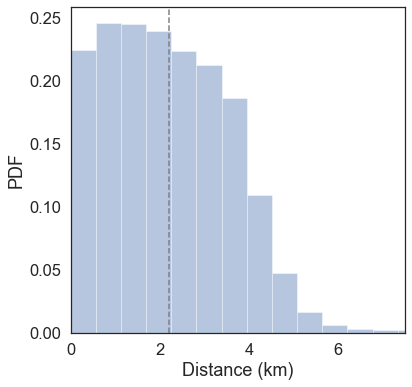

In [8]:
# Histogram of glider sample distances

dist = np.r_[0, gt.utils.distance(dat.longitude, dat.latitude).cumsum()]

dist_gridded = gt.grid_data(x, y, dist[:-1])


import seaborn as sns
plt.figure(figsize=[6, 6])
sns.set(font_scale=1.5)
sns.set_style('white')


sns.distplot(np.diff(dist_gridded[:,:],axis=1)/1000,bins=20,norm_hist=True,kde=False)
plt.axvline(np.nanmean(np.diff(dist_gridded[:,:],axis=1)/1000),linestyle='dashed',c='grey')
plt.ylabel('PDF')
plt.xlabel('Distance (km)')
plt.xlim(0,7.5)
#plt.savefig('figures/sg643_divedistance.png',bbox_inches='tight',transparent=True)

In [9]:
np.nanstd(np.diff(dist_gridded[:,:],axis=1)/1000)

1.4009062484589243

In [10]:
# Add heat map of dive locations
lon_gridded = gt.grid_data(x, y, dat.longitude)
lat_gridded = gt.grid_data(x, y, dat.latitude)

Mean bin size = 1.00
Mean depth binned (50 m) vertical sampling frequency = 0.94
Mean bin size = 1.00
Mean depth binned (50 m) vertical sampling frequency = 0.94


/Users/isabelle/anaconda3/envs/giddy2020/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/isabelle/anaconda3/envs/giddy2020/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(-0.4, -59.75, 'Bow-tie')

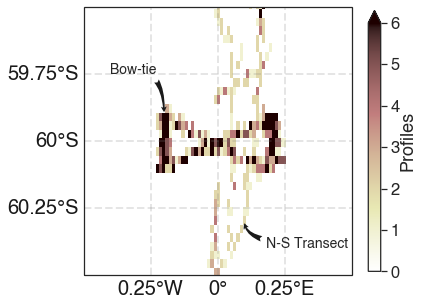

In [11]:
# Plot of glider sampling density

import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size':18})
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

projection =ccrs.PlateCarree()#
data_crs=ccrs.PlateCarree()
fig=plt.figure(figsize=[6,6])
ax = plt.axes(projection=projection)

img=plt.hist2d( lon_gridded.values[10, :][~np.isnan(lon_gridded.values[10, :])], lat_gridded.values[10, :][~np.isnan(lat_gridded.values[10, :])], 
           cmap=plt.cm.pink_r, bins=40,transform=data_crs,vmin=0,vmax=6)

ax.set_extent([-0.5,0.5,-60.5,-59.5])

cb=plt.colorbar(shrink=0.8,extend='max')
cb.set_label('Profiles', labelpad=0.01)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.2, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([-0.5,-0.25, 0, 0.25,0.5])
gl.ylocator = mticker.FixedLocator([-60.5,-60.25,-60,-59.75,-59,-58.5,-58])

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 20, 'color': 'k'}

gl.ylabel_style = {'size': 20, 'color': 'k'}

ax.annotate('N-S Transect', xy=(0.1,-60.3),  xycoords='data',
            xytext=(0.18,-60.4),fontsize=14,
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.1", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90"))

ax.annotate('Bow-tie', xy=(-0.2,-59.9),  xycoords='data',
            xytext=(-0.4,-59.75),fontsize=14,
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.1", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90"))

#plt.savefig('figures/sg643_diveheatmap.png',transparent=False,bbox_inches='tight',dpi=100)

# Compare to ship ctd


In [12]:
# Load bottle data
ctd_miz, date_miz, lon_miz, lat_miz = agulhas_ctd.read_ship_CTD('data/sg643/ship_data_SANAE_58/stn003/stn003.cnv')
ctd_miz2, date_miz2, lon_miz2, lat_miz2 = agulhas_ctd.read_ship_CTD('data/sg643/ship_data_SANAE_58/stn036/stn036.cnv')

functions/ctdCalibration/agulhas_ctd.py:36: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  x = pd.read_csv(filePath, sep='/t', skiprows=9, header=None)


(550.0, 0.0)

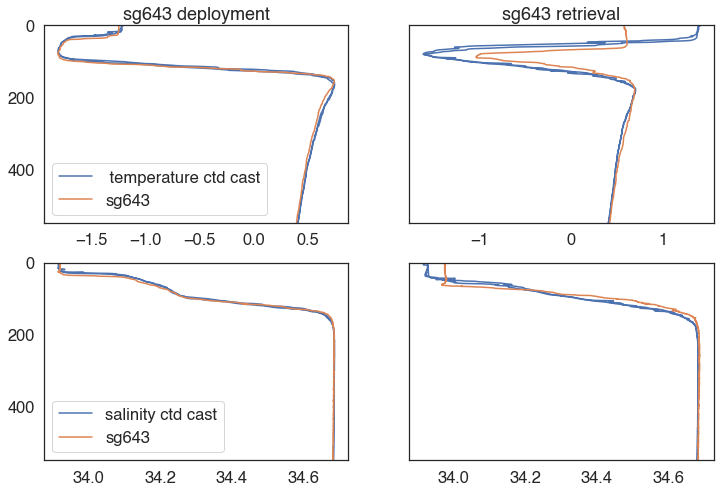

In [13]:
fig,ax=plt.subplots(2,2,figsize=[12,8],sharey=True)
ax[0,0].set_title('sg643 deployment')
ax[0,0].plot(ctd_miz['Temperature'],ctd_miz['Pressure[db]'],label=' temperature ctd cast')
ax[0,0].plot(dat.temp[dat.dives==5.5],dat.depth[dat.dives==5.5],label='sg643')
ax[0,0].legend()

ax[0,1].set_title('sg643 retrieval')
ax[0,1].plot(ctd_miz2['Temperature'],ctd_miz2['Pressure[db]'])
ax[0,1].plot(dat.temp[dat.dives==503.5],dat.depth[dat.dives==503.5])
ax[0,1].set_ylim(550,0)

ax[1,0].plot(ctd_miz['Salinity'],ctd_miz['Pressure[db]'],label='salinity ctd cast')
ax[1,0].plot(dat.salt[dat.dives==5.5],dat.depth[dat.dives==5.5],label='sg643')
ax[1,0].legend()

ax[1,1].plot(ctd_miz2['Salinity'],ctd_miz2['Pressure[db]'])
ax[1,1].plot(dat.salt[dat.dives==503.5],dat.depth[dat.dives==503.5])
ax[1,1].set_ylim(550,0)


#plt.savefig('figures/t&scal.png')

## Clean

In [33]:
for key in dat:
    dat[key][x==55.0]=np.nan
    dat[key][x==64.5]=np.nan

In [38]:
# Reload with updated dives
x = dat.dives
y = dat.depth
pres = dat.pressure
lats = dat.latitude
lons = dat.longitude

In [39]:
# Clean temp and salnity, calculate density and mld
salt_qc=gt.cleaning.rolling_window(dat.salt, mean, window=3)
temp_qc=gt.cleaning.rolling_window(dat.temp, mean, window=3)
SA_qc=gsw.SA_from_SP(salt_qc,dat.depth,dat.longitude,dat.latitude)
CT_qc=gsw.CT_from_t(SA_qc,temp_qc,dat.depth)
dens0=gt.physics.potential_density(salt_qc, temp_qc, pres, lats, lons)


mld= gt.physics.mixed_layer_depth(x, y, dens0,ref_depth=10, thresh=0.03)
mld2=np.array(mld[::2])
#n2=gsw.Nsquared(SA_qc,CT_qc,y)[1]


In [41]:
# Raw values - used later for thermal lag analysis

salt_qc_raw=gt.cleaning.rolling_window(dat.salt_raw, mean, window=3)
temp_qc_raw=gt.cleaning.rolling_window(dat.temp_raw, mean, window=3)
SA_qc_raw=gsw.SA_from_SP(salt_qc_raw,dat.depth,dat.longitude,dat.latitude)
CT_qc_raw=gsw.CT_from_t(SA_qc_raw,temp_qc_raw,dat.depth)
dens0_raw=gt.physics.potential_density(salt_qc_raw, temp_qc_raw, pres, lats, lons)
mld_raw = gt.physics.mixed_layer_depth(x, y, dens0_raw,ref_depth=10, thresh=0.03)




In [20]:
dat['SA_qc']=xr.DataArray(SA_qc,dims=('ctd_data_point'))
dat['CT_qc']=xr.DataArray(CT_qc,dims=('ctd_data_point'))
dat['dens0']=xr.DataArray(dens0,dims=('ctd_data_point'))

In [14]:
#dat.reset_coords().to_netcdf(os.path.join(datadir,'sg643_clean.nc'))

# Horizontal Linear Gridding 

Gridding of glider data for submesoscale analysis is required as the lateral gradients can be biased to the sampling resolution. 

A few methods can be adopted to regrid the data.
1. Linear Gridding (simple)
2. Objective Mapping (based on weighted means)
3. Gaussian Process Regression (supervised machine learning based on probabilities)

The advantages of the more complex methods is increased accuracy/confidence intervals, but decreased interperatability and increased computational expense. 
A disadvantage of Objective Mapping is the difficulty of determining the lengthscales of the covariance functions. These are often determined using educated guesses. 
GPR improves on this by using machine learning techniques to learn the best parameters from the data. 

In the light of simplicity, for this analysis, the data was linearly interpolated. Future work will focus on implementing GPR. 


In [21]:
time_raw=np.int64(dat.time)//10**9 * 10**9
dist = np.r_[0, gt.utils.distance(dat.longitude, dat.latitude).cumsum()]
dens0 = dat.dens0
hdist=np.arange(0,2074322,1000)

In [50]:
vertical_grid_res=1

dives=np.arange(1.0,x.max(),0.5)   # max dives is 503.5


dive=[]
salt_binned=[]
temp_binned=[]
dens_binned=[]
dist_binned=[]
time_binned=[]
lat_binned=[]
lon_binned=[]

xi=np.arange(0,999,vertical_grid_res)
for i in dives:
    try:
        if np.int(np.str(i)[-1])==0:
            lat_binned.append(np.interp(xi,dat.depth[dat.dives==i],dat.latitude[dat.dives==i]))
            lon_binned.append(np.interp(xi,dat.depth[dat.dives==i],dat.longitude[dat.dives==i]))
            salt_binned.append(np.interp(xi,dat.depth[dat.dives==i],dat.SA_qc[dat.dives==i]))
            temp_binned.append(np.interp(xi,dat.depth[dat.dives==i],dat.CT_qc[dat.dives==i]))
            dens_binned.append(np.interp(xi,dat.depth[dat.dives==i],dat.dens0[dat.dives==i]))
            dist_binned.append(np.interp(xi,dat.depth[dat.dives==i],dist[:-1][dat.dives==i]))
            time_binned.append(np.interp(xi,dat.depth[dat.dives==i],time_raw[dat.dives==i]))


            dive.append(np.ones(len(xi))*i)
        else:
            lat_binned.append(np.interp(xi,dat.depth[dat.dives==i][::-1],dat.latitude[dat.dives==i][::-1]))
            lon_binned.append(np.interp(xi,dat.depth[dat.dives==i][::-1],dat.longitude[dat.dives==i][::-1]))
            salt_binned.append(np.interp(xi,dat.depth[dat.dives==i][::-1],dat.SA_qc[dat.dives==i][::-1]))
            temp_binned.append(np.interp(xi,dat.depth[dat.dives==i][::-1],dat.CT_qc[dat.dives==i][::-1]))
            dens_binned.append(np.interp(xi,dat.depth[dat.dives==i][::-1],dat.dens0[dat.dives==i][::-1]))
            dist_binned.append(np.interp(xi,dat.depth[dat.dives==i][::-1],dist[:-1][dat.dives==i][::-1]))
            time_binned.append(np.interp(xi,dat.depth[dat.dives==i][::-1],time_raw[dat.dives==i][::-1]))

            dive.append(np.ones(len(xi))*i)
    except ValueError: 
        continue
dens_binned=np.array(dens_binned)
dist_binned=np.array(dist_binned)
time_binned=np.array(time_binned)
salt_binned=np.array(salt_binned)
temp_binned=np.array(temp_binned)
lat_binned=np.array(lat_binned)
lon_binned=np.array(lon_binned)

In [35]:
import pandas as pd

xi=np.arange(0,999,1)

# Then interpolate on the horizontal


salt_horz=[]
temp_horz=[]
dens_horz=[]
time_horz=[]
lon_horz=[]
lat_horz=[]


for i in range(len(xi)-1):
        dens_horz.append(pd.Series(np.interp(hdist,dist_binned[:,i],dens_binned[:,i])).rolling(1).mean())
        temp_horz.append(pd.Series(np.interp(hdist,dist_binned[:,i],temp_binned[:,i])).rolling(1).mean())
        salt_horz.append(pd.Series(np.interp(hdist,dist_binned[:,i],salt_binned[:,i])).rolling(1).mean())
        lat_horz.append(pd.Series(np.interp(hdist,dist_binned[:,i],lat_binned[:,i])).rolling(1).mean())
        lon_horz.append(pd.Series(np.interp(hdist,dist_binned[:,i],lon_binned[:,i])).rolling(1).mean())

        time_horz.append(pd.Series(np.interp(hdist,dist_binned[:,i],time_binned[:,i])).rolling(1).mean())

dens_horz=np.array(dens_horz)
time_horz=np.array(time_horz)
lon_horz=np.array(lon_horz)
lat_horz=np.array(lat_horz)
salt_horz=np.array(salt_horz)
temp_horz=np.array(temp_horz)


time=np.array(pd.to_datetime(pd.Series(time_horz.flatten()//10**9*10**9))).reshape(len(xi)-1,np.size(hdist))

#####################################

glider_linterp = xr.Dataset(
                 data_vars={
                     'lat':  (('depth','distance'), lat_horz),
                     'lon':  (('depth','distance'), lon_horz),
                     'time':    (('depth','distance'), time),
                     'salt': (('depth','distance'),salt_horz ),
                     'temp': (('depth','distance'),temp_horz ),
                     'dens': (('depth','distance'),dens_horz )
                     },
                 coords={'depth': xi[:-1],
                         'distance': hdist},)

In [39]:
glider_linterp.attrs["processing"] = "This data has been cleaned and linearly interpolated first in the vertical to 1m bins and then in the horizontal to 1km horizontal resolution"

In [40]:
glider_linterp.reset_coords().to_netcdf('data/sg643/sg643_linterp.nc')

In [ ]:
# Linearly grid data along isopycnals

In [31]:
import pandas as pd

x=dat.dives
y=dens0

vertical_grid_res=0.01

dives=np.arange(1.0,x.max(),0.5)   # max dives is 503.5


dive=[]
salt_binned=[]
temp_binned=[]
depth_binned=[]
dist_binned=[]
time_binned=[]
lat_binned=[]
lon_binned=[]

xi=np.arange(1027,1028,vertical_grid_res)
for i in dives:
    try:
        if np.int(np.str(i)[-1])==0:
            lat_binned.append(np.interp(xi,dat.dens0[dat.dives==i],dat.latitude[dat.dives==i]))
            lon_binned.append(np.interp(xi,dat.dens0[dat.dives==i],dat.longitude[dat.dives==i]))
            salt_binned.append(np.interp(xi,dat.dens0[dat.dives==i],dat.SA_qc[dat.dives==i]))
            temp_binned.append(np.interp(xi,dat.dens0[dat.dives==i],dat.CT_qc[dat.dives==i]))
            depth_binned.append(np.interp(xi,dat.dens0[dat.dives==i],dat.depth[dat.dives==i]))
            dist_binned.append(np.interp(xi,dat.dens0[dat.dives==i],dist[:-1][dat.dives==i]))
            time_binned.append(np.interp(xi,dat.dens0[dat.dives==i],time_raw[dat.dives==i]))


            dive.append(np.ones(len(xi))*i)
        else:
            lat_binned.append(np.interp(xi,dat.dens0[dat.dives==i][::-1],dat.latitude[dat.dives==i][::-1]))
            lon_binned.append(np.interp(xi,dat.dens0[dat.dives==i][::-1],dat.longitude[dat.dives==i][::-1]))
            salt_binned.append(np.interp(xi,dat.dens0[dat.dives==i][::-1],dat.SA_qc[dat.dives==i][::-1]))
            temp_binned.append(np.interp(xi,dat.dens0[dat.dives==i][::-1],dat.CT_qc[dat.dives==i][::-1]))
            depth_binned.append(np.interp(xi,dat.dens0[dat.dives==i][::-1],dat.depth[dat.dives==i][::-1]))
            dist_binned.append(np.interp(xi,dat.dens0[dat.dives==i][::-1],dist[:-1][dat.dives==i][::-1]))
            time_binned.append(np.interp(xi,dat.dens0[dat.dives==i][::-1],time_raw[dat.dives==i][::-1]))

            dive.append(np.ones(len(xi))*i)
    except ValueError: 
        continue
depth_binned=np.array(depth_binned)
dist_binned=np.array(dist_binned)
time_binned=np.array(time_binned)
salt_binned=np.array(salt_binned)
temp_binned=np.array(temp_binned)
lat_binned=np.array(lat_binned)
lon_binned=np.array(lon_binned)

##########################################################

salt_horz=[]
temp_horz=[]
depth_horz=[]
time_horz=[]
lon_horz=[]
lat_horz=[]

for i in range(len(xi)-1):
        depth_horz.append(pd.Series(np.interp(hdist,dist_binned[:,i],depth_binned[:,i])).interpolate())
        temp_horz.append(pd.Series(np.interp(hdist,dist_binned[:,i],temp_binned[:,i])).interpolate())
        salt_horz.append(pd.Series(np.interp(hdist,dist_binned[:,i],salt_binned[:,i])).interpolate())
        lat_horz.append(pd.Series(np.interp(hdist,dist_binned[:,i],lat_binned[:,i])).interpolate())
        lon_horz.append(pd.Series(np.interp(hdist,dist_binned[:,i],lon_binned[:,i])).interpolate())
        time_horz.append(pd.Series(np.interp(hdist,dist_binned[:,i],time_binned[:,i])).interpolate())
        
depth_horz=np.array(depth_horz)
time_horz=np.array(time_horz)
lon_horz=np.array(lon_horz)
lat_horz=np.array(lat_horz)
salt_horz=np.array(salt_horz)
temp_horz=np.array(temp_horz)

time=np.array(pd.to_datetime(pd.Series(time_horz.flatten()//10**9*10**9))).reshape(len(xi)-1,np.size(hdist))

#####################################

glider_linterp_dens = xr.Dataset(
                 data_vars={
                     'lat':  (('density','distance'), lat_horz),
                     'lon':  (('density','distance'), lon_horz),
                     'time':    (('density','distance'), time),
                     'salinity': (('density','distance'),salt_horz ),
                     'sea_water_temperature': (('density','distance'),temp_horz ),
                     'depth': (('density','distance'),depth_horz )
                     },
                 coords={'density': xi[:-1],
                         'distance': hdist})

In [32]:
glider_linterp_dens.attrs["processing"] = "This data has been cleaned, interpolated first onto equal density surfaces and linearly interpolated to 1km horizontal resolution"

In [34]:
# Save to nc
glider_linterp_dens.to_netcdf('data/sg643/sg643_grid_density_surfaces.nc')

# Compute thermal lag error

Disclaimer: this code is very hacky.  
I need to clean it up

In [22]:
def grid_data(
    x,
    y,
    var,
    bins=None,
    how='mean',
    interp_lim=6,
    verbose=True,
    return_xarray=True,
):
    """
    Grids the input variable to bins for depth/dens (y) and time/dive (x).
    The bins can be specified to be non-uniform to adapt to variable sampling
    intervals of the profile. It is useful to use the ``gt.plot.bin_size``
    function to identify the sampling intervals. The bins are averaged (mean)
    by default but can also be the ``median, std, count``,

    Parameters
    ----------
    x : np.array, dtype=float, shape=[n, ]
        The horizontal values by which to bin need to be in a psudeo discrete
        format already. Dive number or ``time_average_per_dive`` are the
        standard inputs for this variable. Has ``p`` unique values.
    y : np.array, dtype=float, shape=[n, ]
        The vertical values that will be binned; typically depth, but can also
        be density or any other variable.
    bins : np.array, dtype=float; shape=[q, ], default=[0 : 1 : max_depth ]
        Define the bin edges for y with this function. If not defined, defaults
        to one meter bins.
    how : str, defualt='mean'
        the string form of a function that can be applied to pandas.Groupby
        objects. These include ``mean, median, std, count``.
    interp_lim : int, default=6
        sets the maximum extent to which NaNs will be filled.

    Returns
    -------
    glider_section : xarray.DataArray, shape=[p, q]
        A 2D section in the format specified by ``ax_xarray`` input.

    Raises
    ------
    Userwarning
        Triggers when ``x`` does not have discrete values.
    """
    from pandas import cut, Series
    from xarray import DataArray
    from numpy import array, c_, unique, diff

    xvar, yvar = x.copy(), y.copy()
    z = Series(var)
    y = array(y)
    x = array(x)

    u = unique(x).size
    s = x.size
    if (u / s) > 0.2:
        raise UserWarning(
            'The x input array must be psuedo discrete (dives or dive_time). '
            '{:.0f}% of x is unique (max 20% unique)'.format(u / s * 100)
        )

    chunk_depth = 50
    optimal_bins, avg_sample_freq = get_optimal_bins(y, chunk_depth)
    if bins is None:
        bins = optimal_bins

    # warning if bin average is smaller than average bin size
    if verbose:
        avg_bin_size = diff(bins).mean()
        print(
            (
                'Mean bin size = {:.2f}\n'
                'Mean depth binned ({} m) vertical sampling frequency = {:.2f}'
            ).format(avg_bin_size, chunk_depth, avg_sample_freq)
        )

    labels = c_[bins[:-1], bins[1:]].mean(axis=1)
    bins = cut(y, bins, labels=labels)

    grp = Series(z).groupby([x, bins])
    grp_agg = getattr(grp, how)()
    gridded = grp_agg.unstack(level=0)
    gridded = gridded.reindex(labels.astype(float))

    if interp_lim > 0:
        gridded = gridded.interpolate(limit=interp_lim).bfill(limit=interp_lim)

    if not return_xarray:
        return gridded

    if return_xarray:
        dummy = transfer_nc_attrs(getframe(), var, var, '_vert_binned')

        xda = gridded.stack().to_xarray()
        if isinstance(var, DataArray):
            xda.attrs = dummy.attrs
            xda.name = dummy.name

        if isinstance(yvar, DataArray):
            y = xda.dims[0]
            xda[y].attrs = yvar.attrs
            xda = xda.rename({y: yvar.name})

        if isinstance(xvar, DataArray):
            x = xda.dims[1]
            xda[x].attrs = xvar.attrs
            xda = xda.rename({x: xvar.name})

        return xda


def get_optimal_bins(depth, chunk_depth=50, round_up=True):
    """
    Uses depth data to estimate the optimal bin depths for gridding.

    Data is grouped in 50 m chunks (default for chunk_depth) where the
    average sequential depth difference is used to estimate the binning
    resolution for that chunk. The chunk binning resolution is rounded to
    the upper/lower 0.5 metres (specified by user).

    Parameters
    ----------
    depth : array
        A sequential array of depth (concatenated dives)
    chunk_depth : float=50
        chunk depth over which the bin sizes will be calculated
    round_up : True
        if True, rounds up to the nearest 0.5 m, else rounds down.

    Returns
    -------
    bins : array
    bin_avg_sampling_freq : float
        un-rounded depth weighted depth sampling frequency (for verbose use)

    """

    from numpy import (
        abs,
        arange,
        array,
        diff,
        ceil,
        floor,
        isnan,
        nanmax,
        nanmedian,
    )

    y = array(depth)
    bins = []
    bin_avg_sampling_freq = []

    if round_up:
        round_func = ceil
    else:
        round_func = floor

    d0 = 0
    d1 = chunk_depth
    last_freq = 0.5
    while d0 <= nanmax(depth):
        i = (y > d0) & (y < d1)

        bin_avg_sampling_freq += (nanmedian(abs(diff(y[i]))),)
        bin_freq = round_func(bin_avg_sampling_freq[-1] * 2) / 2
        if bin_freq == 0:
            bin_freq = 0.5
        elif isnan(bin_freq):
            bin_freq = last_freq
        bin_step = arange(d0, d1, bin_freq).tolist()
        bins += bin_step

        d0 = bin_step[-1] + bin_freq
        d1 = d0 + chunk_depth

        last_freq = bin_freq

    return array(bins), nanmedian(bin_avg_sampling_freq)


def grid_flat_dataarray(xda, bins=None):
    """
    Will grid an xr.DataArray if it contains coordinates correct metadata

    Parameters
    ----------
    xda : xr.DataArray
        flattened profile array with coordinates:
        (axis='T' | 'time' in name) and (axis='Z' | 'depth' in name)

    Returns a gridded dataset
    -------------------------
    """
    from .helpers import GliderToolsError

    has_requirements = 0
    for key in xda.coords:
        coord = xda[key]
        attrs = coord.attrs
        if ('Z' in attrs.get('axis', '').upper()) | ('depth' in coord.name):
            depth = coord
            has_requirements += 1
        if 'dives' in coord.name:
            dives = coord
            has_requirements += 1
    if has_requirements == 2:
        x = dives
        y = depth
        z = xda

        gridded = grid_data(
            x, y, z, bins=bins, return_xarray=True, verbose=False
        )
        return gridded
    else:
        raise GliderToolsError(
            'The array coordinates do not contain axis info for gridding'
        )




In [25]:
def mygridding(var,dives,depth):

    from pandas import cut, Series
    from xarray import DataArray
    from numpy import array, c_, unique, diff

    xvar, yvar = dives.copy(), depth.copy()
    z = Series(var)
    y = array(depth)
    x = array(dives)

    u = unique(x).size
    s = x.size
    if (u / s) > 0.2:
        raise UserWarning(
            'The x input array must be psuedo discrete (dives or dive_time). '
            '{:.0f}% of x is unique (max 20% unique)'.format(u / s * 100)
        )

    chunk_depth = 50

    bins=np.arange(0,1000,1)

    labels = c_[bins[:-1], bins[1:]].mean(axis=1)
    bins = cut(y, bins, labels=labels)

    grp = Series(z).groupby([x, bins])

    how='mean'
    grp_agg = getattr(grp, how)()
    gridded = grp_agg.unstack(level=0)
    gridded = gridded.reindex(labels.astype(float))
    
    return gridded

#optimal_bins, avg_sample_freq = get_optimal_bins(y, chunk_depth)

In [42]:
salt_grid=mygridding(dat.salt,dat.dives,dat.depth)
temp_grid = mygridding(dat.temp,dat.dives,dat.depth)
salt_grid_raw=mygridding(dat.salt_raw,dat.dives,dat.depth)
temp_grid_raw=mygridding(dat.temp_raw,dat.dives,dat.depth)

In [43]:
dens_grid = mygridding(dens0,dat.dives,dat.depth)
dens_grid_raw=mygridding(dens0_raw,dat.dives,dat.depth)

In [44]:
### TEMPERATURE
diff_temp=[]
for i in np.arange(1,971,2):
    diff_temp.append(np.array(temp_grid.iloc[:,i]-temp_grid.iloc[:,i+1]))
diff_temp=np.array(diff_temp)
diff_temp_raw=[]
for i in np.arange(1,971,2):
    diff_temp_raw.append(np.array(temp_grid_raw.iloc[:,i]-temp_grid_raw.iloc[:,i+1]))
diff_temp_raw=np.array(diff_temp_raw)

temp_mean_raw=np.nanmean(diff_temp_raw,0)
temp_std_raw=np.nanstd(diff_temp_raw,0)
temp_mean_corr=np.nanmean(diff_temp,0)
temp_std_corr=np.nanstd(diff_temp,0)


### SALINITY
diff_salt=[]
for i in np.arange(1,971,2):
    diff_salt.append(np.array(salt_grid.iloc[:,i]-salt_grid.iloc[:,i+1]))
diff_salt=np.array(diff_salt)
diff_salt_raw=[]
for i in np.arange(1,971,2):
    diff_salt_raw.append(np.array(salt_grid_raw.iloc[:,i]-salt_grid_raw.iloc[:,i+1]))
diff_salt_raw=np.array(diff_salt_raw)

salt_mean_raw=np.nanmean(diff_salt_raw,0)
salt_std_raw=np.nanstd(diff_salt_raw,0)
salt_mean_corr=np.nanmean(diff_salt,0)
salt_std_corr=np.nanstd(diff_salt,0)

### DENSITY
diff_dens=[]
for i in np.arange(1,971,2):
    diff_dens.append(np.array(dens_grid.iloc[:,i]-dens_grid.iloc[:,i+1]))
diff_dens=np.array(diff_dens)
diff_dens_raw=[]
for i in np.arange(1,971,2):
    diff_dens_raw.append(np.array(dens_grid_raw.iloc[:,i]-dens_grid_raw.iloc[:,i+1]))
diff_dens_raw=np.array(diff_dens_raw)

dens_mean_raw=np.nanmean(diff_dens_raw,0)
dens_std_raw=np.nanstd(diff_dens_raw,0)
dens_mean_corr=np.nanmean(diff_dens,0)
dens_std_corr=np.nanstd(diff_dens,0)

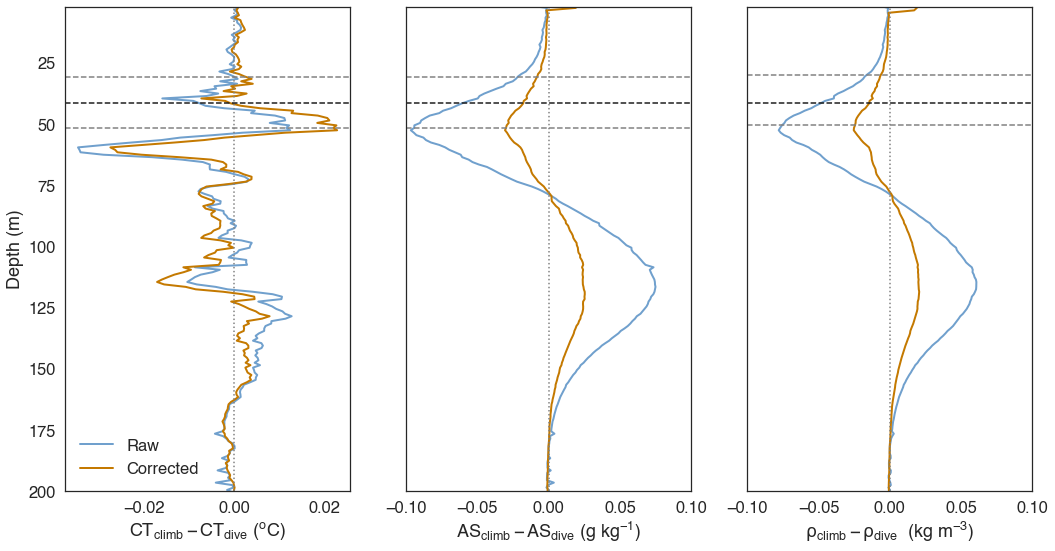

In [45]:
fig,ax=plt.subplots(1,3,figsize=[15,8],sharey=True)

raw = (112/255,160/255,205/255)
corr = (196/255,121/255,0)

#plt.rc('text', usetex=True, )
plt.rcParams.update({'font.size': 18})
ax[0].plot(temp_mean_raw[1:],temp_grid.index[1:],label='Raw',c=raw,linewidth=2)

ax[0].plot(temp_mean_corr,temp_grid.index,label='Corrected',c=corr,linewidth=2)

ax[0].axhline(y=np.nanmean(mld),c='k',linestyle='--')
ax[0].axhline(y=np.nanmean(mld)-np.nanstd(mld),c='Grey',linestyle='--')
ax[0].axhline(y=np.nanmean(mld)+np.nanstd(mld),c='Grey',linestyle='--')

ax[0].axvline(x=0,c='Grey',linestyle=':')
ax[0].set_ylim(200,2)
ax[0].legend(frameon=False, loc='lower left')
ax[0].set_xlabel(u'$CT_{climb}-CT_{dive}\ (^{o}C)$')
#ax[0].text(0.01,185,'RMSE=2e$^{-4}$')

######################################################################


ax[1].plot(salt_mean_raw[:],salt_grid_raw.index[:],label='Raw',c=raw,linewidth=2)

ax[1].plot(salt_mean_corr[:],salt_grid.index[:],label='Corrected',c=corr,linewidth=2)
ax[1].axhline(y=np.nanmean(mld)-np.nanstd(mld),c='Grey',linestyle='--')
ax[1].axhline(y=np.nanmean(mld),c='k',linestyle='--')

ax[1].axhline(y=np.nanmean(mld)+np.nanstd(mld),c='Grey',linestyle='--')
ax[1].axvline(x=0,c='Grey',linestyle=':')
ax[1].set_ylim(200,2)
ax[1].set_xlim(-0.1,0.1)


#ax[1].legend(frameon=False)
ax[1].set_xlabel(u'$AS_{climb}-AS_{dive}$ (g kg$^{-1})$')
#ax[1].text(0.05,185,'RMSE=3e$^{-3}$')

######################################################################


ax[2].plot(dens_mean_raw[:],dens_grid_raw.index[:],label='Raw',c=raw,linewidth=2)
ax[2].plot(dens_mean_corr[:],dens_grid.index,label='Corrected',c=corr,linewidth=2)

ax[2].axhline(y=np.nanmean(mld.rolling(2).median()),c='k',linestyle='--')
ax[2].axhline(y=np.nanmean(mld[::2])-np.nanstd(mld[::2]),c='Grey',linestyle='--')
ax[2].axhline(y=np.nanmean(mld[::2])+np.nanstd(mld[::2]),c='Grey',linestyle='--')


ax[2].axvline(x=0,c='Grey',linestyle=':')
#ax[2].fill_betweenx(dens_grid.index,-0.03,0.03,facecolor='Grey',alpha=0.2)

ax[2].set_ylim(200,2)
ax[2].set_xlim(-0.1,0.1)


#ax[2].legend(frameon=False)
ax[2].set_xlabel(u'$\\rho_{climb}-\\rho_{dive}$  (kg $m^{-3})$')
#ax[2].text(0.045,185,'RMSE=3e$^{-3}$')

ax[0].set_ylabel('Depth (m)')
plt.tight_layout()

#plt.savefig('figures/thermal_lag_ud.png',dpi=150)

In [46]:
### TEMPERATURE
diff_temp=[]
for i in np.arange(2,972,2):
    diff_temp.append(np.array(temp_grid.iloc[:,i]-temp_grid.iloc[:,i+1]))
diff_temp=np.array(diff_temp)
diff_temp_raw=[]
for i in np.arange(2,972,2):
    diff_temp_raw.append(np.array(temp_grid_raw.iloc[:,i]-temp_grid_raw.iloc[:,i+1]))
diff_temp_raw=np.array(diff_temp_raw)

temp_mean_raw=np.nanmean(diff_temp_raw,0)
temp_std_raw=np.nanstd(diff_temp_raw,0)
temp_mean_corr=np.nanmean(diff_temp,0)
temp_std_corr=np.nanstd(diff_temp,0)


### SALINITY
diff_salt=[]
for i in np.arange(2,972,2):
    diff_salt.append(np.array(salt_grid.iloc[:,i]-salt_grid.iloc[:,i+1]))
diff_salt=np.array(diff_salt)
diff_salt_raw=[]
for i in np.arange(2,972,2):
    diff_salt_raw.append(np.array(salt_grid_raw.iloc[:,i]-salt_grid_raw.iloc[:,i+1]))
diff_salt_raw=np.array(diff_salt_raw)

salt_mean_raw=np.nanmean(diff_salt_raw,0)
salt_std_raw=np.nanstd(diff_salt_raw,0)
salt_mean_corr=np.nanmean(diff_salt,0)
salt_std_corr=np.nanstd(diff_salt,0)

### DENSITY
diff_dens=[]
for i in np.arange(2,972,2):
    diff_dens.append(np.array(dens_grid.iloc[:,i]-dens_grid.iloc[:,i+1]))
diff_dens=np.array(diff_dens)
diff_dens_raw=[]
for i in np.arange(2,972,2):
    diff_dens_raw.append(np.array(dens_grid_raw.iloc[:,i]-dens_grid_raw.iloc[:,i+1]))
diff_dens_raw=np.array(diff_dens_raw)

dens_mean_raw=np.nanmean(diff_dens_raw,0)
dens_std_raw=np.nanstd(diff_dens_raw,0)
dens_mean_corr=np.nanmean(diff_dens,0)
dens_std_corr=np.nanstd(diff_dens,0)

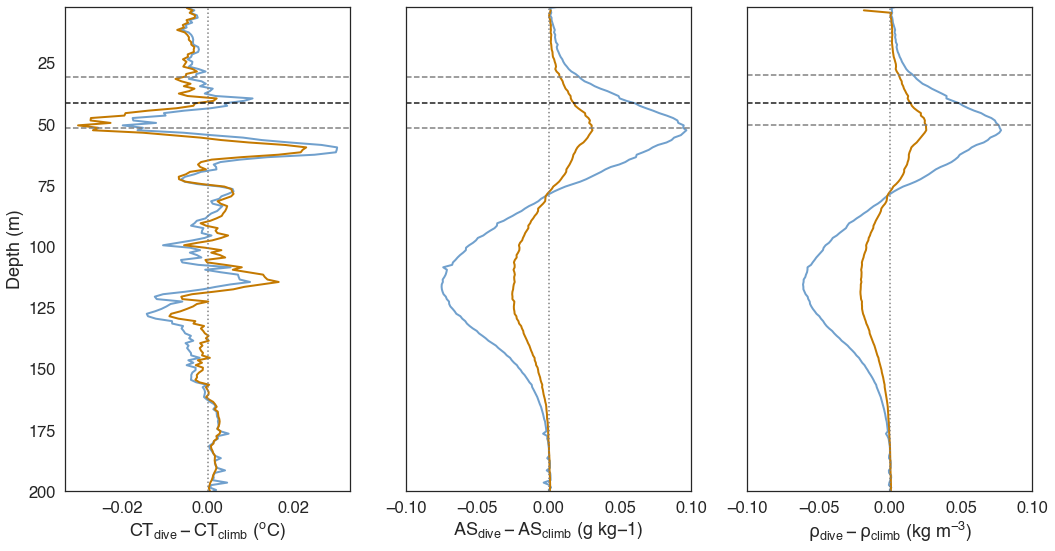

In [48]:
# Plot differeces in processing

fig,ax=plt.subplots(1,3,figsize=[15,8],sharey=True)



#plt.rc('text', usetex=True, )
plt.rcParams.update({'font.size': 18})
ax[0].plot(temp_mean_raw[1:],temp_grid.index[1:],label='Raw',c=raw,linewidth=2)

ax[0].plot(temp_mean_corr,temp_grid.index,label='Corrected',c=corr,linewidth=2)

ax[0].axhline(y=np.nanmean(mld),c='k',linestyle='--')
ax[0].axhline(y=np.nanmean(mld)-np.nanstd(mld),c='Grey',linestyle='--')
ax[0].axhline(y=np.nanmean(mld)+np.nanstd(mld),c='Grey',linestyle='--')

ax[0].axvline(x=0,c='Grey',linestyle=':')
ax[0].set_ylim(200,0)
#ax[0].legend(frameon=False)
ax[0].set_xlabel(u'$CT_{dive}-CT_{climb}\ (^{o}C)$')
#ax[0].text(0.01,185,'RMSE=2e$^{-4}$')

######################################################################


ax[1].plot(salt_mean_raw[:],salt_grid_raw.index[:],label='Raw',c=raw,linewidth=2)

ax[1].plot(salt_mean_corr[:],salt_grid.index[:],label='Corrected',c=corr,linewidth=2)
ax[1].axhline(y=np.nanmean(mld)-np.nanstd(mld),c='Grey',linestyle='--')
ax[1].axhline(y=np.nanmean(mld),c='k',linestyle='--')

ax[1].axhline(y=np.nanmean(mld)+np.nanstd(mld),c='Grey',linestyle='--')
ax[1].axvline(x=0,c='Grey',linestyle=':')
ax[1].set_ylim(200,2)
ax[1].set_xlim(-0.1,0.1)


#ax[1].legend(frameon=False)
ax[1].set_xlabel(u'$AS_{dive}-AS_{climb}$ (g $kg{-1})$')
#ax[1].text(0.05,185,'RMSE=3e$^{-3}$')


######################################################################



ax[2].plot(dens_mean_raw[:],dens_grid_raw.index[:],label='Raw',c=raw,linewidth=2)
ax[2].plot(dens_mean_corr[:],dens_grid.index,label='Corrected',c=corr,linewidth=2)

ax[2].axhline(y=np.nanmean(mld.rolling(2).median()),c='k',linestyle='--')
ax[2].axhline(y=np.nanmean(mld[::2])-np.nanstd(mld[::2]),c='Grey',linestyle='--')
ax[2].axhline(y=np.nanmean(mld[::2])+np.nanstd(mld[::2]),c='Grey',linestyle='--')


ax[2].axvline(x=0,c='Grey',linestyle=':')
#ax[2].fill_betweenx(dens_grid.index,-0.03,0.03,facecolor='Grey',alpha=0.2)

ax[2].set_ylim(200,2)
ax[2].set_xlim(-0.1,0.1)


#ax[2].legend(frameon=False)
ax[2].set_xlabel(u'$\\rho_{dive}-\\rho_{climb}}$ (kg $m^{-3})$')
#ax[2].text(0.045,185,'RMSE=3e$^{-3}$')

ax[0].set_ylabel('Depth (m)')
plt.tight_layout()

#plt.savefig('figures/thermal_lag_du.png',dpi=150)

### Compute and plot differences in up/down down/up within the mixed layer 


In [49]:

### Density
diff_dens=[]
for i in np.arange(1,549,2):
    diff_dens.append(np.array(dens_grid.iloc[:,i]-dens_grid.iloc[:,i+1]))
   
diff_dens=np.array(diff_dens)
diff_dens_raw=[]
for i in np.arange(1,549,2):
    diff_dens_raw.append(np.array(dens_grid_raw.iloc[:,i]-dens_grid_raw.iloc[:,i+1]))
diff_dens_raw=np.array(diff_dens_raw)

In [50]:
diff_dens2=[]
for i in np.arange(0,972,2):
    diff_dens2.append(np.array(dens_grid.iloc[:,i]-dens_grid.iloc[:,i+1]))

diff_dens2=np.array(diff_dens2)
diff_dens_raw2=[]
for i in np.arange(0,972,2):
    diff_dens_raw2.append(np.array(dens_grid_raw.iloc[:,i]-dens_grid_raw.iloc[:,i+1]))
diff_dens_raw2=np.array(diff_dens_raw2)

In [51]:
dist = np.r_[0, gt.utils.distance(dat.longitude, dat.latitude).cumsum()]
dist_grid=gt.grid_data(x, y, dist[:-1], verbose=False)

/Users/isabelle/anaconda3/envs/giddy2020/lib/python3.8/site-packages/glidertools/helpers.py:69: GliderToolsWarning: Primary input variable is not xr.DataArray data type - no metadata to pass on.
  warnings.warn(msg, category=GliderToolsWarning)


In [52]:
# DISTANCE
diff_dist=[]
for i in np.arange(2,972,2):
 #   print(dist_grid.dives[i])
 #   print(dist_grid.dives[i+1])
 #   print('next')
    diff_dist.append(np.array(dist_grid[:,i]-dist_grid[:,i+1]))
diff_dist=np.array(diff_dist)

In [53]:
# DISTANCE
diff_dist2=[]
for i in np.arange(1,971,2):
 #   print(dist_grid.dives[i])
 #   print(dist_grid.dives[i+1])
 #   print('next')
    diff_dist2.append(np.array(dist_grid[:,i]-dist_grid[:,i+1]))
diff_dist2=np.array(diff_dist2)

In [56]:
dens_diff_mld=[]
depth_diff=[]

plt.figure()
#for i in range(len(mld2-2)):
for i in range(26):

    try:
        diff_count=((diff_dens[i,3:(np.int8(mld2[i])-15)]))
        diff_Dist=((diff_dist[i,3:(np.int8(mld2[i])-15)]))

        plot(diff_count,dens_grid.depth[3:(np.int8(mld2[i])-15)])
        #plt.axhline(y=mld2[i])
        plt.ylim(150,10)
        dens_diff_mld.append((np.nanmean(diff_count)))
        dens_diff_dist.append((np.nanmean(diff_count)))
        depth_diff.append((dens_grid.depth[3:(np.int8(mld2[i])-15)]))
        


    except: continue# print(i)
        
for i in range(28,163):

    try:
        diff_count=((diff_dens[i,3:(np.int8(mld2[i])-15)]))
        plot(diff_count,dens_grid.depth[3:(np.int8(mld2[i])-15)])
       # plt.axhline(y=mld2[i])
        plt.ylim(150,10)
        dens_diff_mld.append((np.nanmean(diff_count)))
        depth_diff.append((dens_grid.depth[3:(np.int8(mld2[i])-15)]))



    except: continue# print(i)
        
dens_diff_mld=[]
depth_diff=[]   
diff_dist_mld=[]
for i in range(0,486):

    try:
        diff_count=((diff_dens[i,3:(np.int8(mld2[i])-15)]))
        plot(diff_count,dens_grid.depth[3:(np.int8(mld2[i])-15)])
        diff_Dist=((diff_dist[i,3:(np.int8(mld2[i])-15)]))
        diff_dist_mld.append(diff_Dist)
       # plt.axhline(y=mld2[i])
        plt.ylim(150,10)
        dens_diff_mld.append(((np.nanmean(diff_count))/(np.nanmean(diff_Dist)))*1000)
        depth_diff.append((dens_grid.depth[3:(np.int8(mld2[i])-15)]))



    except: continue #print(i)
        
 #   print(salt_diff[:(np.int8

<Figure size 432x288 with 0 Axes>

In [57]:
dens_diff_mld2=[]
depth_diff2=[]

plt.figure()
#for i in range(len(mld2-2)):
for i in range(26):

    try:
        diff_count2=((diff_dens2[i,3:(np.int8(mld[i])-15)]))
        diff_Dist2=((diff_dist2[i,3:(np.int8(mld[i])-15)]))

        plot(diff_count2,dens_grid.depth[3:(np.int8(mld[i])-15)])
        #plt.axhline(y=mld2[i])
        plt.ylim(150,10)
        dens_diff_mld2.append((np.nanmean(diff_count2)))
        salt_diff_dist2.append((np.nanmean(diff_count2)))
        depth_diff2.append((dens_grid.depth[3:(np.int8(mld[i])-15)]))
        


    except: continue# print(i)
        
for i in range(28,163):

    try:
        diff_count=((diff_dens2[i,3:(np.int8(mld[i])-15)]))
        plot(diff_count2,dens_grid.depth[3:(np.int8(mld[i])-15)])
       # plt.axhline(y=mld2[i])
        plt.ylim(150,10)
        dens_diff_mld2.append((np.nanmean(diff_count2)))
        depth_diff2.append((dens_grid.depth[3:(np.int8(mld[i])-15)]))



    except: continue# print(i)
        
dens_diff_mld=[]
depth_diff=[]   
diff_dist_mld=[]
for i in range(0,486):

    try:
        diff_count=((diff_dens[i,3:(np.int8(mld2[i])-15)]))
        plot(diff_count,dens_grid.depth[3:(np.int8(mld2[i])-15)])
        diff_Dist=((diff_dist[i,3:(np.int8(mld2[i])-15)]))
        diff_dist_mld.append(diff_Dist)
       # plt.axhline(y=mld2[i])
        plt.ylim(150,10)
        dens_diff_mld.append(((np.nanmean(diff_count))/(np.nanmean(diff_Dist)))*1000)
        depth_diff.append((dens_grid.depth[3:(np.int8(mld2[i])-15)]))



    except: continue# print(i)
        
 #   print(salt_diff[:(np.int8

<Figure size 432x288 with 0 Axes>

In [58]:
#up down
dens_diff_mld_raw=[]
dens_diff_mld=[]

depth_diff=[]   
diff_dist_mld=[]
for i in range(0,972):

    try:
        diff_count1=((diff_dens[i,10:(np.int8(mld2[i])-15)]))
        diff_count2=((diff_dens_raw[i,10:(np.int8(mld2[i])-15)]))

      #  plot(diff_count,salt_grid.depth[10:(np.int8(mld2.iloc[i])-15)])
        diff_Dist=((diff_dist[i,3:(np.int8(mld2[i])-15)]))
        diff_dist_mld.append(np.nanmean(diff_Dist))
       # plt.axhline(y=mld2[i])
      #  plt.ylim(150,10)
        #salt_diff_mld.append(((np.nanmean(diff_count))/(np.nanmean(diff_Dist)))*1000)
        dens_diff_mld.append(((np.nanmean(diff_count1))/333)*1000)
        dens_diff_mld_raw.append(((np.nanmean(diff_count2))/333)*1000)


      #  depth_diff.append((salt_grid.depth[3:(np.int8(mld2.iloc[i])-15)]))



    except: continue #print(i)

In [59]:
diff_dist2

array([[ -338.95193301,  -350.21594546,  -353.39222896, ...,
                   nan,            nan,            nan],
       [ -103.54362317,  -119.19688764,  -122.7814107 , ...,
                   nan,            nan,            nan],
       [ -234.49489504,  -246.65929505,  -247.81799804, ...,
                   nan,            nan,            nan],
       ...,
       [  -99.935805  ,  -116.25072388,  -120.41962663, ...,
                   nan,            nan,            nan],
       [  -80.26017792,   -83.34614056,   -85.23630059, ...,
                   nan,            nan,            nan],
       [ -142.55467864,  -146.69778964,  -150.56124017, ...,
        -4539.4903773 , -4539.4903773 , -4539.4903773 ]])

In [60]:
#down up
dens_diff_mld_raw2=[]
dens_diff_mld2=[]

depth_diff2=[]   
diff_dist_mld2=[]
for i in range(0,972):

    try:
        diff_count3=((diff_dens2[i,10:(np.int8(mld2[i])-15)]))
        diff_count4=((diff_dens_raw2[i,10:(np.int8(mld2[i])-15)]))

      #  plot(diff_count,salt_grid.depth[10:(np.int8(mld2.iloc[i])-15)])
        diff_Dist=((diff_dist2[i,3:(np.int8(mld2[i])-15)]))
        diff_dist_mld2.append(np.nanmean(diff_Dist))
       # plt.axhline(y=mld2[i])
      #  plt.ylim(150,10)
        #salt_diff_mld.append(((np.nanmean(diff_count))/(np.nanmean(diff_Dist)))*1000)
        dens_diff_mld2.append(((np.nanmean(diff_count3))/2000)*1000)
        dens_diff_mld_raw2.append(((np.nanmean(diff_count4))/2000)*1000)


      #  depth_diff.append((salt_grid.depth[3:(np.int8(mld2.iloc[i])-15)]))



    except: continue #print(i)

In [61]:
import pandas as pd
sd=pd.Series(dens_diff_mld).interpolate()
sdRAW = pd.Series(dens_diff_mld_raw).interpolate()

sd2=pd.Series(dens_diff_mld2).interpolate()
sdRAW2 = pd.Series(dens_diff_mld_raw2).interpolate()

import seaborn as sns

Text(0.5, 0, '$ \\Delta$ kg m$^{-3}$ km$^{-1}$')

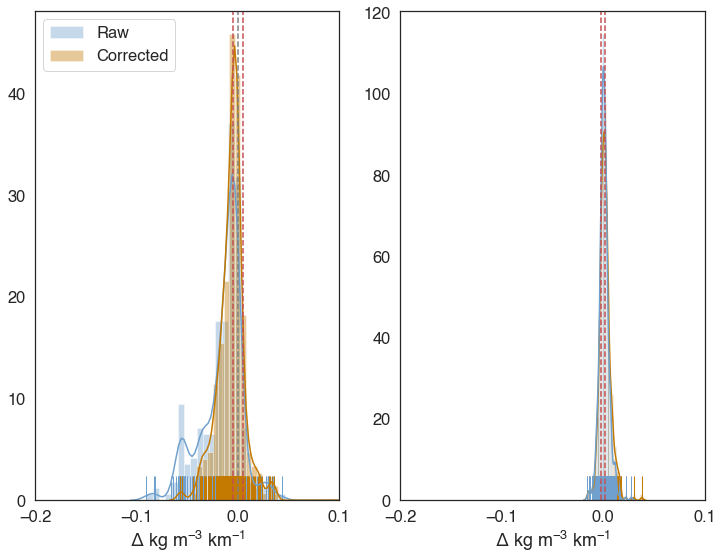

In [62]:
import seaborn as sns
plt.rcParams.update({'font.size': 18})


fig,ax=plt.subplots(1,2,figsize=[12,9],sharex=True)
sns.distplot(sdRAW, hist=True, rug=True,label='Raw',ax=ax[0],color=raw)


sns.distplot(sd, hist=True, rug=True,label='Corrected',ax=ax[0],color=corr)

sns.distplot(sdRAW2, hist=True, rug=True,label='Raw_DU',ax=ax[1],color=corr)
sns.distplot(sd2, hist=True, rug=True,label='Corrected_DU',ax=ax[1],color=raw)


ax[0].set_xlim(-0.2,0.1)
ax[0].axvline(0,c='Grey',linestyle='--')
ax[0].axvline(-0.005,c='r',linestyle='--')
ax[0].axvline(+0.005,c='r',linestyle='--')
ax[1].axvline(-0.002,c='r',linestyle='--')
ax[1].axvline(+0.002,c='r',linestyle='--')
ax[0].legend()

ax[0].set_xlabel(r'$ \Delta$ kg m$^{-3}$ km$^{-1}$')
ax[1].set_xlabel(r'$ \Delta$ kg m$^{-3}$ km$^{-1}$')

#ax[0].set_title('Up Down ')
#ax[1].set_title('Down Up ')

#plt.savefig('/Users/isabelle/src/roammiz/Figures/TL_analysis_dens.png',dpi=150)

In [ ]:
# rmsw= 0.005
# 0.002

